# Fisher Criterion Beamformer - spatial filter to extract features from ErrP data
### Jupyter notebook version (Python Toolbox also available) 
For the purpose of this example, it is useful to know that the datasets use:   
 - 12 EEG channels: order [1-Fz 2-Cz 3-C3 4-C4 5-CPz 6-Pz 7-P3 8-P4 9-PO7 10-PO8 11-POz 12-Oz]
 - sampling frequency: fs = 256 Hz
 - dataset is filtered [1-10] Hz
 - epochs are all 1 second long

 - this example is self-explanatory from code and comments - just run and select the dataset
 - to show the discrimination effect of FCB r-square is applied on data before and after FCB filtering 

 If you use the FCB toolbox please refer to [1]
 If you use the datasets please refer to [2] and [3]

References:
- [1] Gabriel Pires, Urbano Nunes and  Miguel Castelo-Branco (2011), "Statistical Spatial Filtering for 
     a P300-based BCI: Tests in able-bodied, and Patients with Cerebral Palsy and Amyotrophic Lateral 
     Sclerosis", Journal of Neuroscience Methods, Elsevier, 2011, 195(2), 
     Feb. 2011: doi:10.1016/j.jneumeth.2010.11.016
     https://www.sciencedirect.com/science/article/pii/S0165027010006503?via%3Dihub
- [2] https://ieee-dataport.org/open-access/error-related-potentials-primary-and-secondary-errp-and-p300-event-related-potentials-%E2%80%93
- [3] https://ieeexplore.ieee.org/abstract/document/8048036

@author: Gabriel Pires, April 2023


Importing some required Python libraries 

In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

Loading the ErrP dataset (obtained  from one of our communication spellers (LSC) [2][3])

In [3]:
data  = loadmat('data\ErrP_LSC_dataset.mat')
data.keys()
data1 = data['ErrP_LSC_dataset']   #structure with ErrP and correctERP
data1.dtype                     
yt = data1[0,0]['ErrP']            #ErrP samples (1 second  epochs)
ynt = data1[0,0]['CorrERP']        #Correct Event Related Potentials samples (1 second  epochs)
    
label1='ErrP'
label2='Correct'    
    
print('ERRP DATASET\n')
print('Variable yt:   ErrP epochs         - %d channels x %d time samples x %d Error trials \n', np.size(yt,0),np.size(yt,1),np.size(yt,2));
print('Variable ynt:  Correct  ERP epochs - %d channels x %d time samples x %d Correct trials \n', np.size(ynt,0),np.size(ynt,1),np.size(ynt,2));

ERRP DATASET

Variable yt:   ErrP epochs         - %d channels x %d time samples x %d Error trials 
 12 256 28
Variable ynt:  Correct  ERP epochs - %d channels x %d time samples x %d Correct trials 
 12 256 162


## Plotting the mean and standard deviation of ErrPs and Correct ERPs

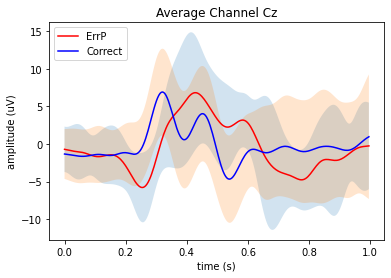

In [4]:
fs = 256;                             # sampling frequency: 256 Hz
Ts = 1/ fs;
#t=[0 : 256-1]*1/fs;                  # 1 second trial

x = np.arange(fs);
t = np.multiply(x,Ts)

# Average of data (targets (ErrPs) and non-targets (Correct ERPs))
yt_mean = np.mean(yt, axis=2) 
yt_std  = np.std(yt,axis=2);
ynt_mean = np.mean(ynt,axis=2)
ynt_std  = np.std(ynt,axis=2)
#np.size(yt,2)

#plot average
ch = 2  # channel Cz
#ax1 = plt.subplot(3,1,1)
plt.plot(t,yt_mean[ch,:],'r',label=label1)
plt.plot(t,ynt_mean[ch,:],'b', label=label2)
plt.xlabel('time (s)')
plt.ylabel('amplitude (uV)')
plt.title('Average Channel Cz')
plt.legend(loc = 'upper left')
plt.fill_between(t,yt_mean[ch,:]+yt_std[ch,:], yt_mean[ch,:]-yt_std[ch,:], alpha=0.2)
plt.fill_between(t,ynt_mean[ch,:]+ynt_std[ch,:], ynt_mean[ch,:]-ynt_std[ch,:], alpha=0.2)
plt.show()


## Functions for Feature discrimination and colormap plot

from https://www.bci2000.org/mediawiki/index.php/Glossary#r-squared

r2 version adjusted to Python
and r2 color map visualization

In [5]:
import pylab

"""
r2 computation
"""
def rsquare(q,r):
    sum1 = np.sum(q);
    sum2 = np.sum(r);
    n1=np.size(q, axis=0);
    n2=np.size(r, axis=0);
    sumsqu1=np.sum(np.multiply(q,q));
    sumsqu2=np.sum(np.multiply(r,r));

    G=((sum1+sum2)**2)/(n1+n2);

    erg=(sum1**2/n1+sum2**2/n2-G)/(sumsqu1+sumsqu2-G);
    return erg

def plot_rsquare(t,ressq):
    data2plot = np.transpose(ressq)
    
    tamx=np.shape(data2plot)
    #print(tamx[0])  
    data2plot = np.concatenate( (data2plot, np.zeros((tamx[0],1)) ), 1)
    tamx=np.shape(data2plot)

    #print(np.shape(data2plot))  
    data2plot = np.concatenate( (data2plot, np.zeros((1,tamx[1])) ), 0)
    xData=t;
    xData=np.append(xData, xData[-1] + np.diff(xData[len(xData)-2 : len(xData)]));

    Nch=np.size(ressq, axis=1)

    #ax.pcolormesh(xData,np.arange(Nch+1),data2plot, vmin=-0.5, vmax=1.0)
    # ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
    pylab.pcolor(xData, np.arange(Nch+1), data2plot, cmap=plt.cm.jet )
    pylab.colorbar()
    pylab.ylabel('Channels')
    pylab.xlabel('time (s)')
    pylab.title('Statistical r^2 between class1 and class2')
    pylab.show() 
    
    return 0

Applying r-square

<ipython-input-5-0002c324fa04>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolor(xData, np.arange(Nch+1), data2plot, cmap=plt.cm.jet )


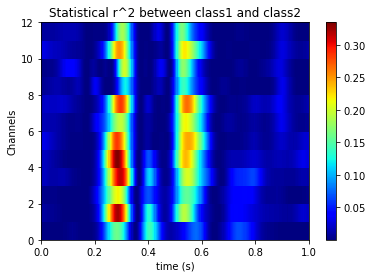

In [7]:
#analysis of feature discrimination with r-square of raw data
N_ch = np.size(yt, 0);              #channels
N_samp = np.size(yt, 1);            #time samples
rsq = np.zeros((N_samp, N_ch));     #initialize variable
#np.size(rsq,0)

#ax2 = plt.subplot(3,1,2)
#plt.subplots_adjust(hspace = 0.5)
for ch in np.arange(N_ch):
    for samp in np.arange(N_samp):
        rsq[samp, ch] = rsquare(yt[ch, samp,:],ynt[ch, samp,:])

plot_rsquare(t,rsq)
del rsq

## Function to obtain FCB spatial filters
- Spatial BETWEEN-MATRIX and WITHIN-MATRIX are obtained in the spatial domain
- The Eigenvectors (spatial filters) and eigenvalues are obtained from the Rayleigh quotient:
- $J(W) = \frac{W'S_nW}{W'S_wW}$


In [9]:
def FCB_spatial_filters(z1,z2,th):
    Mean1 = np.mean(z1,axis=2)
    Mean2 = np.mean(z2,axis=2)

    Cov1=np.zeros((np.size(z1,0),np.size(z1,0),np.size(z1,2)))
    Cov2=np.zeros((np.size(z2,0),np.size(z2,0),np.size(z2,2)))
    
    for i in np.arange(np.size(z1,2)):     #for each trial in class 1 
        aux1=(z1[:,:,i]-Mean1) @ np.transpose(z1[:,:,i]-Mean1)
        Cov1[:,:,i]=aux1 / (np.trace(aux1));            #normalized spatial covariance per trial 

    for i in np.arange(np.size(z2,2)):     #for each trial in class 1 
        aux2=(z2[:,:,i]-Mean2) @ np.transpose(z2[:,:,i]-Mean2)
        Cov2[:,:,i]=aux2 / (np.trace(aux2));
        
    p1=np.size(z1,2)/(np.size(z1,2)+np.size(z2,2))
    p2=np.size(z2,2)/(np.size(z1,2)+np.size(z2,2))
    
    Covavg1=np.sum(Cov1,2); #covariances sum class 1  
    Covavg2=np.sum(Cov2,2); #covariances sum class 2 
    
    MeanAll=p1*Mean1 + p2*Mean2   #unbalanced classes

    #Spatial BETWEEN-CLASS MATRIX
    Sb=p1*(Mean1-MeanAll) @ np.transpose(Mean1-MeanAll) + p2*(Mean2-MeanAll) @ np.transpose(Mean2-MeanAll)  

    #Spatial WITHIN-CLASS MATRIX
    Sw=p1*Covavg1 + p2*Covavg2 
    Sw= (1-th)*Sw + th*np.eye(np.size(Sw,0),np.size(Sw,0))  
    
    V1, U1 = np.linalg.eig(np.linalg.pinv(Sw) @ Sb)
       
    
    rindices = np.argsort(-1*V1); 
    
    Vd1 = V1[rindices]               #ordered eigenvalues 
    #print(Vd1)
    V1 = np.diag(Vd1)                      
    U1 = U1[:,rindices]              #ordered eigenvectors (spatial filters)
    
    return U1, V1

## Function to obtain Spatial filter Projections
- $Y=W'X$

In [10]:
def FCB_projections(z1,z2,U):
    #initialize variables
    z1_f=np.zeros((np.size(z1,0),np.size(z1,1),np.size(z1,2)))
    z2_f=np.zeros((np.size(z2,0),np.size(z2,1),np.size(z2,2)))
  
    for i in np.arange(np.size(z1,2)):    #trials class 1
        z1_f[:,:,i] = np.transpose(U) @ np.squeeze(z1[:,:,i])

    for i in np.arange(np.size(z2,2)):    #trials class 2
        z2_f[:,:,i] = np.transpose(U) @ np.squeeze(z2[:,:,i])
    
    return z1_f, z2_f

# Applying FCB to ErrP dataset and plotting spatially filtered data

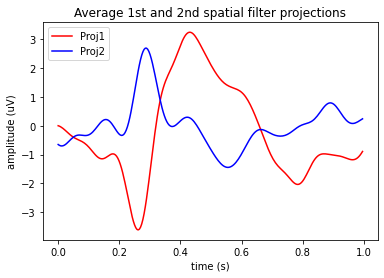

In [11]:
# obtaining FCB statistical spatial filters
U, V = FCB_spatial_filters(yt, ynt, 0.1)


# Projections obtained from spatial filters
ytf , yntf = FCB_projections(yt, ynt, U)

# Average of data (targets and non-targets)
ytf_mean = np.mean(ytf, axis=2) 
ytf_std  = np.std(ytf,axis=2);
yntf_mean = np.mean(yntf,axis=2);
yntf_std  = np.std(yntf,axis=2);

plt.plot(t,ytf_mean[0,:],'r',label='Proj1')
plt.plot(t,ytf_mean[1,:],'b', label='Proj2')
plt.xlabel('time (s)')
plt.ylabel('amplitude (uV)')
plt.title('Average 1st and 2nd spatial filter projections')
plt.legend(loc = 'upper left')
plt.show()

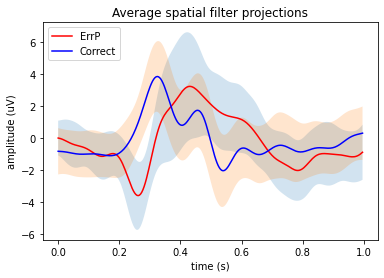

In [12]:
plt.plot(t,ytf_mean[0,:],'r',label=label1)
plt.plot(t,yntf_mean[0,:],'b', label=label2)
plt.xlabel('time (s)')
plt.ylabel('amplitude (uV)')
plt.title('Average spatial filter projections')
plt.legend(loc = 'upper left')
plt.fill_between(t,ytf_mean[0,:]+ytf_std[0,:], ytf_mean[0,:]-ytf_std[0,:], alpha=0.2)
plt.fill_between(t,yntf_mean[0,:]+yntf_std[0,:], yntf_mean[0,:]-yntf_std[0,:], alpha=0.2)
plt.show()

# R-square discrimination of spatially filtered data

<ipython-input-5-0002c324fa04>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolor(xData, np.arange(Nch+1), data2plot, cmap=plt.cm.jet )


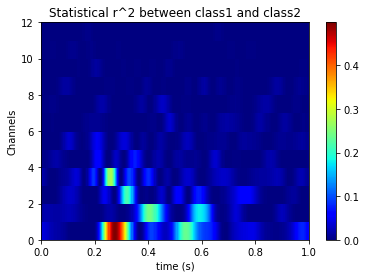

In [14]:
#analysis of feature discrimination with r-square of spatially filtered data
N_ch = np.size(ytf, 0);              #channels
N_samp = np.size(ytf, 1);            #time samples
rsq = np.zeros((N_samp, N_ch));     #initialize variable

for ch in np.arange(N_ch):
    for samp in np.arange(N_samp):
        rsq[samp, ch] = rsquare(ytf[ch, samp,:],yntf[ch, samp,:])

plot_rsquare(t,rsq)
del rsq